<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/test_regimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Data preprocessing step
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_excel('/content/MEF_2019.xlsx')

# Remove duplicate dates
data.drop(data.loc[data['Date'].duplicated()].index, inplace=True)

# Set 'Date' as the index and drop the 'Date' column
data.set_index(data['Date'], inplace=True)
data.drop(columns=['Date'], inplace=True)

# Display the last few rows of the data
print("Tail of the data:")
print(data.tail())

# Check for missing values
missing_rows = data[data.isna().any(axis=1)].tail()
cols_with_missing = data.columns[data.isna().any()].tolist()

# Prepare and print text results for missing values
if missing_rows.empty:
    result_text = "No rows with missing values found."
else:
    result_text = f"Rows with missing values:\n{missing_rows.to_string(index=False)}"

if not cols_with_missing:
    result_text += "\n\nNo columns with missing values."
else:
    result_text += f"\n\nColumns with missing values: {', '.join(cols_with_missing)}"

print(result_text)

# Handle negative values in 'Generation'
num_neg_values = (data['Generation'] < 0).sum()
data.loc[data['Generation'] < 0, 'Generation'] = 0

# Handle zero values in 'Generation' by setting corresponding 'Emissions' to zero
num_zero_generation = (data['Generation'] == 0).sum()
data.loc[data['Generation'] == 0, 'Emissions'] = 0

# Display the results of handling negative and zero values
print(f"Negative values in Generation: {'Yes' if num_neg_values > 0 else 'No'}")
print(f"Number of negative values converted to zero: {num_neg_values}")
print(f"Number of zero values in Generation: {num_zero_generation}")
print(f"Number of Emissions converted to zero: {num_zero_generation}")

# Calculate the first difference of the time series
ret = data - data.shift(1)
ret = ret[1:]  # Eliminate the first row which will be NaN

# Display the differenced data
print("First difference of the data:")
print(ret)

# Standardize the 'Generation' and 'Emissions' columns
scaler = StandardScaler()
ret[['Generation', 'Emissions']] = scaler.fit_transform(ret[['Generation', 'Emissions']])

# Display the standardized data
print("Standardized data:")
print(ret)

# Check for missing values in the standardized data
missing_rows_ret = ret[ret.isna().any(axis=1)].tail()
cols_with_missing_ret = ret.columns[ret.isna().any()].tolist()

# Prepare and print text results for missing values in the standardized data
if missing_rows_ret.empty:
    result_text_ret = "No rows with missing values found."
else:
    result_text_ret = f"Rows with missing values:\n{missing_rows_ret.to_string(index=False)}"

if not cols_with_missing_ret:
    result_text_ret += "\n\nNo columns with missing values."
else:
    result_text_ret += f"\n\nColumns with missing values: {', '.join(cols_with_missing_ret)}"

print(result_text_ret)


Tail of the data:
                         Emissions    Generation
Date                                            
2019-12-31 18:59:59.982        730  2.483138e+07
2019-12-31 19:59:59.982        683  5.269565e+07
2019-12-31 20:59:59.982        645  5.269565e+07
2019-12-31 21:59:59.982        579  2.263845e+07
2019-12-31 22:59:59.982        512  2.096735e+07
No rows with missing values found.

No columns with missing values.
Negative values in Generation: No
Number of negative values converted to zero: 0
Number of zero values in Generation: 0
Number of Emissions converted to zero: 0
First difference of the data:
                         Emissions    Generation
Date                                            
2019-01-01 00:59:59.983        0.0  0.000000e+00
2019-01-01 01:59:59.983       42.0  6.071983e+06
2019-01-01 02:59:59.983      -35.0 -6.071983e+06
2019-01-01 04:00:00.000        0.0  0.000000e+00
2019-01-01 04:59:59.983      -92.0  0.000000e+00
...                            ...   

Visiulisation inspection

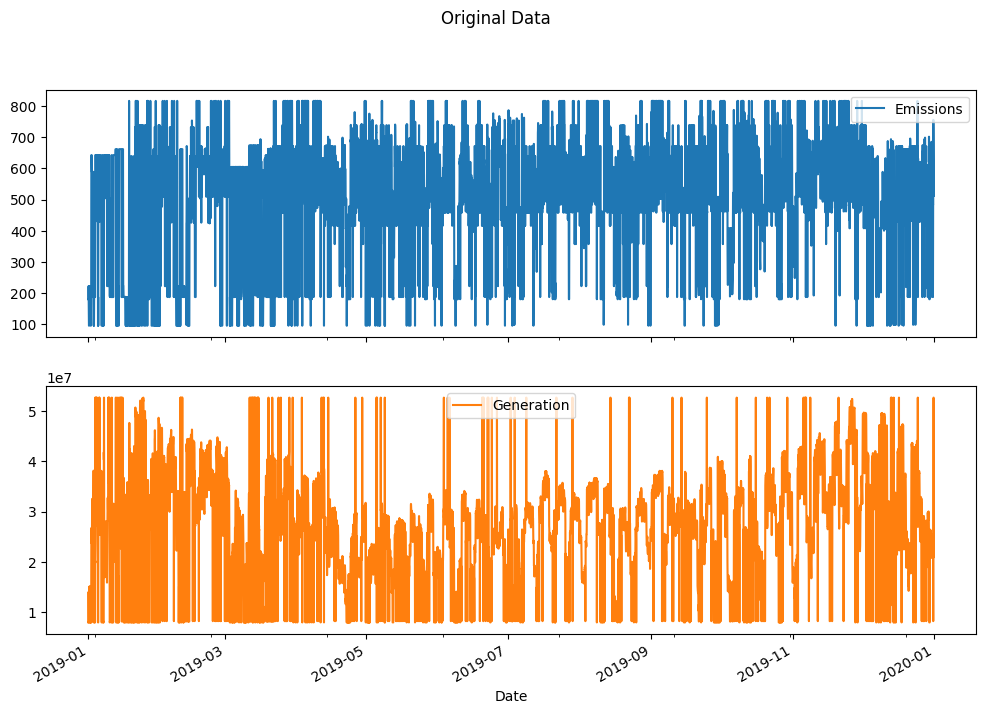

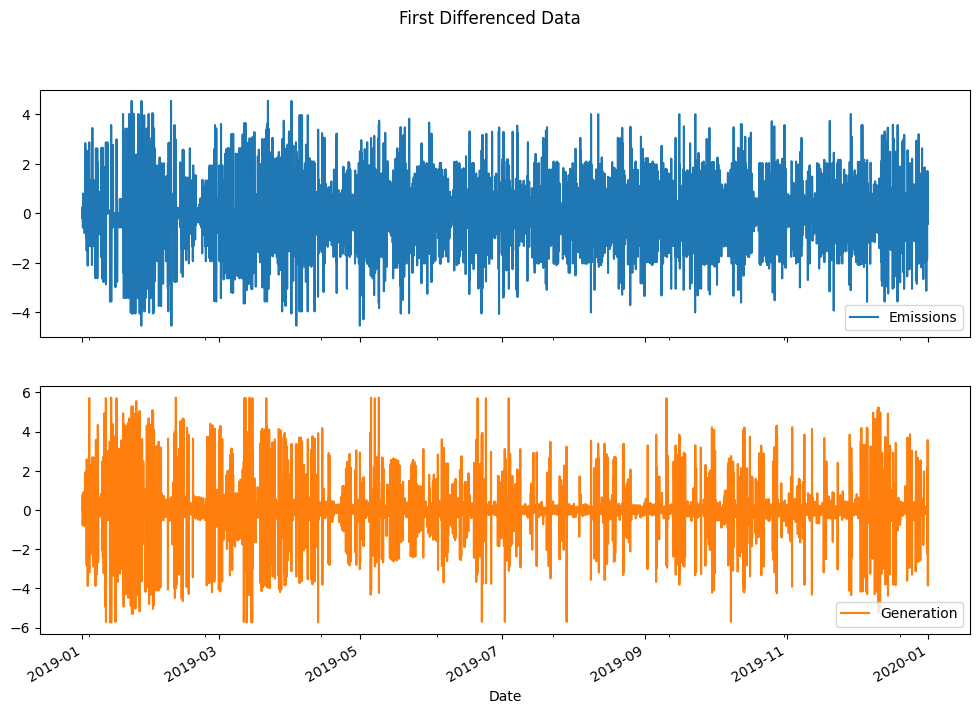

In [5]:
import matplotlib.pyplot as plt

# Plot the original data
data.plot(subplots=True, figsize=(12, 8), title='Original Data')
plt.show()

# Plot the first differenced data
ret.plot(subplots=True, figsize=(12, 8), title='First Differenced Data')
plt.show()


2. Statistical Tests for Structural Breaks


2.1. CUSUM Test

The Cumulative Sum (CUSUM) test is used to detect changes in the mean level of a time series.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import breaks_cusumolsresid

# Apply the CUSUM test on the original and differenced data
cusum_test_orig = breaks_cusumolsresid(data['Generation'])
cusum_test_diff = breaks_cusumolsresid(ret['Generation'])

print(f"CUSUM Test on Original Data:\n{cusum_test_orig}\n")
print(f"CUSUM Test on Differenced Data:\n{cusum_test_diff}\n")


2.2. Chow Test

The Chow test can detect a single structural break at a known point in time.

In [ ]:
from statsmodels.regression.linear_model import OLS
import numpy as np

# Perform the Chow test
split_point = len(data) // 2  # Example: split at the midpoint
data_before = data.iloc[:split_point]
data_after = data.iloc[split_point:]

# Create the regression model
model_before = OLS(data_before['Generation'], np.ones(len(data_before)))
model_after = OLS(data_after['Generation'], np.ones(len(data_after)))

# Fit the models
result_before = model_before.fit()
result_after = model_after.fit()

# Calculate the Chow test statistic
chow_stat = ((result_before.ssr + result_after.ssr) / 2) / (result_before.mse_resid + result_after.mse_resid)
print(f"Chow Test Statistic: {chow_stat}")


2.3. Bai-Perron Test

The Bai-Perron test can detect multiple structural breaks at unknown points in time.

In [ ]:
from statsmodels.tsa.regime_switching import markov_regression

# Use Bai-Perron to detect multiple breaks
bai_perron_result = markov_regression.bai_perron(data['Generation'], max_breaks=5)
print(bai_perron_result.summary())

3. Model Selection Criteria
Compare the goodness-of-fit of different models with varying numbers of regimes using information criteria such as AIC or BIC.

In [ ]:
from statsmodels.tsa.regime_switching import markov_regression

# Fit models with different numbers of regimes and compare AIC/BIC
aic_values = []
bic_values = []
for k in range(1, 5):  # Test 1 to 4 regimes
    model = markov_regression.MarkovRegression(data['Generation'], k_regimes=k)
    result = model.fit()
    aic_values.append(result.aic)
    bic_values.append(result.bic)

print("AIC values for different numbers of regimes:", aic_values)
print("BIC values for different numbers of regimes:", bic_values)
